<a href="https://colab.research.google.com/github/Neoneto/Diamond_Analysis/blob/main/Buying_Price_Prediction_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Buying Price Prediction
Using Convolutional Neural Network, a model that can predict the price per carat of a diamond based on its image is created. The model is trained using several images of diamonds. Even though I have access to the extracted information of the diamonds, in the real world, ordinary buyers don't or doesn't understand any of those in the first place and can only look at the diamond so in this model, only the price an dthe images are used.
The problem is a regression problem and Deep Learning was used, which is typically used for classification problems.

# Import Libraries and Dataset


In [ ]:
# import libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to the images
image_path = '/content/drive/My Drive/Coding Dojo/Diamonds/Images/images'    

In [ ]:
# Define the path to the original dataset
# Will be used for the price
path = '/content/drive/My Drive/Coding Dojo/Diamonds/diamonds_preprocessed.csv'                
pre_processed = pd.read_csv(path)    

# Preparing the Data for the Model

In [ ]:
# Initialize an array to hold the price per carat of each diamond
prices_per_carat = []

# loop through the separate folders containing the images
# Open only the JPEG files, PNG images in the data are not real images of the diamonds
# Open every other image (to reduce the memory used, not necessary for powerful hardware)
# Check if the image is of the right size
  # Other aspect ratios are dropped
  # to maintain info about the aspect ratio
  # Padding might affct results
# Images are resized before storing
  # Not necessary for powerful hardware
# Look for the price of the diamond in the other dataset and store it
def load_images_from_folder(folder):
    # Initialize an array to store images
    images = []
    i = 0
    for filename in os.listdir(folder):
        i += 1
        if filename.endswith(".jpg"):
          if i%2 == 0:
              img = cv2.imread(os.path.join(folder, filename))
              if img is not None:
                if np.shape(np.array(img)) == (300,300,3):
                  if pre_processed.price_per_carat.loc[pre_processed.Id == filename.split('.')[0]].max() < pre_processed.price_per_carat.quantile(0.99)and pre_processed.price_per_carat.loc[pre_processed.Id == filename.split('.')[0]].max() > pre_processed.price_per_carat.quantile(0.01):
                      
                          images.append(cv2.resize(img, (0, 0), fx=0.25, fy=0.25))#(img)
                          prices_per_carat.append(pre_processed.price_per_carat.loc[pre_processed.Id == filename.split('.')[0]].max())
    return images

root_folder = image_path
folders = [os.path.join(root_folder, x) for x in ('round', 'princess', 'pear', 'oval', 'marquise', 'heart', 'emerald', 'cushion')]
all_images = [img for folder in folders for img in load_images_from_folder(folder)]

In [ ]:
# Define target and features
# Convert them to numpy arrays
X = np.array(all_images)
y = np.array(prices_per_carat)

# Attempt to convert the problem into classification, fails
# Group the prices into price categories
# y = np.floor(y/y.max()*10).astype(int)

# split to test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,)

In [ ]:
# Convert the targets into pandas dataframe
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [ ]:
# Scale data between 0 and 1 since images
X_train = X_train / 255

In [ ]:
X_test = X_test / 255

In [ ]:
# Read the input shape
input_shape = X_test.shape[1:]
input_shape

(75, 75, 3)

# CNN

In [ ]:
#from keras.layers.normalization import BatchNormalization

# Initialize the model and the layers
model = Sequential()
#model.add(Dense(256, activation='relu', input_dim=366))
model.add(Conv2D(64, (3, 3), activation='relu', input_shape = input_shape))

model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(64, (3, 3), activation='relu', input_shape = input_shape))

model.add(Conv2D(64, (3, 3), activation='relu', input_shape = input_shape))
#model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(Conv2D(64, (3, 3), init='uniform'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

# For Regression
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))

# Complie the Model
model.compile(loss='mean_squared_error', # one may use 'mean_absolute_error' as  mean_squared_error
                  optimizer='adam',
                  metrics=['mean_squared_error'] # you can add several if needed
                 )

model.summary()

# Code adapted from https://stackoverflow.com/questions/45528285/cnn-image-recognition-with-regression-output-on-tensorflow

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 18496)             0         
                                                                 
 dense (Dense)               (None, 512)               9

The model used two convolutional layers and 2 pooling layers to avoid overfitting.

In [ ]:
# Step 3: Fit our model
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test), 
                    epochs=20)

Epoch 1/20
54/54 [==============================] - 26s 472ms/step - loss: 2877729.7500 - mean_squared_error: 2877729.7500 - val_loss: 743549.8125 - val_mean_squared_error: 743549.8125
Epoch 2/20
54/54 [==============================] - 25s 466ms/step - loss: 836715.9375 - mean_squared_error: 836715.9375 - val_loss: 739431.0625 - val_mean_squared_error: 739431.0625
Epoch 3/20
54/54 [==============================] - 25s 466ms/step - loss: 904993.8125 - mean_squared_error: 904993.8125 - val_loss: 810758.7500 - val_mean_squared_error: 810758.7500
Epoch 4/20
54/54 [==============================] - 25s 467ms/step - loss: 834940.4375 - mean_squared_error: 834940.4375 - val_loss: 727054.3125 - val_mean_squared_error: 727054.3125
Epoch 5/20
54/54 [==============================] - 25s 466ms/step - loss: 839053.0000 - mean_squared_error: 839053.0000 - val_loss: 731050.6250 - val_mean_squared_error: 731050.6250
Epoch 6/20
54/54 [==============================] - 25s 462ms/step - loss: 811484.1

# Model Evaluation

In [ ]:
# Create the test predictions
y_pred = model.predict(X_test)

In [ ]:
# Compare the most accurate prediction
# Smallest error
abs(y_test - y_pred).min()

0    0.427646
dtype: float64

In [ ]:
# Largest error
abs(y_test - y_pred).max()

0    4712.3315
dtype: float64

In [ ]:
# Check the mean of the absolute error
abs(y_test - y_pred).mean()

0    552.871684
dtype: float64

Actual Price: [3970.3]
Predicted Price: [3758.3184]
Percent Error: [0.053]


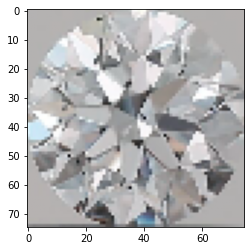

In [ ]:
# Show one of the images and the predicted price compared to the actual
n = 4
print(f'Actual Price: {y_test.to_numpy()[n]}')
print(f'Predicted Price: {y_pred[n]}')
percent = abs(y_pred[n] / y_test.to_numpy()[n] - 1)
print(f'Percent Error: {percent.round(3)}')
plt.imshow(X_test[n])